# PID Regelaar (Controller)

Stel je voor dat je wat melk hebt voorbereid om je baby te voeden, maar de temperatuur van de melk is slechts 25°C en het zou 37°C moeten zijn. De kamertemperatuur is 20°C en dit zal je melk afkoelen. Gelukkig heb je een apparaat dat je melk kan opwarmen. Het apparaat gebruikt elektriciteit om warmte te produceren en je kunt het vermogen $u$ aanpassen. Je kunt ook de temperatuur $T$ van de melk monitoren. Waar je voor staat is een regelprobleem.

Voordat we een oplossing verkennen, laten we wat code schrijven om het scenario te simuleren. We zullen de temperatuurdynamiek modelleren via de wet van Newton over afkoeling.

$$
    \frac{dT}{dt}=\alpha (T_a - T(t)) + \beta u(t)
$$

Hier is $d/dt$ de tijdsafgeleide, $T_a$ is de omgevingstemperatuur en $u$ het vermogen van het verwarmingsapparaat. $\alpha$ en $\beta$ zijn constanten. We gaan niet proberen realistische waarden voor $\alpha$ en $\beta$ voor ons probleem te schatten. Dit is slechts een voorbeeld. Met behulp van de bovenstaande vergelijking, laten we wat simulatiecode schrijven.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
#define constants
alpha, beta = 1, 40
T_ambient, T_desired, T_start = 20, 37, 25

# system update by discretization of the differential eq.
def next_temp(u, T, dt):
    return T+alpha*(T_ambient-T)*dt + beta * u *dt

def simulate_temp(controller, num_steps=20):
    dt = 0.1 # Every time interval dt we set a new control value
    T = T_start
    T_list = [T]
    for k in range(num_steps):
        # ask controller for u value
        u = controller.get_control(T,dt)
        # device only allows to set u between 0 and 1:
        u = np.clip(u, 0, 1)
        # simulate what the temperature will be after time interval dt
        T = next_temp(u, T, dt)
        T_list.append(T)
    time = dt*np.arange(num_steps+1)
    plt.plot(time, np.repeat(T_desired, num_steps+1), ls="--")
    plt.plot(time, T_list)
    plt.xlabel("time"); plt.ylabel("Temperature");

De functie `simulate_temp` heeft een `controller` object als invoer nodig. Deze `controller` heeft een functie `get_control()`, die kijkt naar de huidige temperatuur `T` en de tijd `dT` die is verstreken sinds het laatste besturingscommando werd gegeven. Het vertelt ons naar welk vermogen $u$ we ons verwarmingsapparaat moeten instellen.

Laten we eerst een zeer onzinnige regelaar maken: Hij zal $u$ altijd op nul instellen. Daarom verwarmen we de melk niet en zal deze afkoelen tot de omgevingstemperatuur:

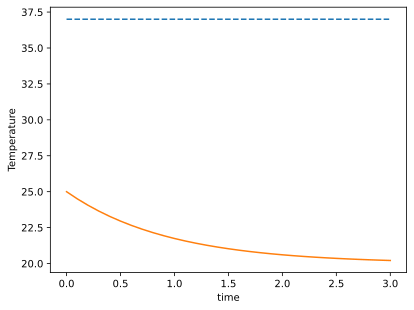

In [4]:
class SillyController:
    def get_control(self,T,dt):
        return 0
silly_controller = SillyController()
simulate_temp(silly_controller, num_steps=30)

Inderdaad, als we niets doen, koelt de melk af. Maar laten we nu proberen een goede regelaar te maken.

## P Regelaar
Het idee van de P-regelaar of proportionele regelaar is eenvoudig: Stel je voor dat je aan een knop draait op het verwarmingsapparaat die de waarde van $u$ instelt. Je kijkt naar het verschil tussen de gewenste temperatuur en de huidige temperatuur, de zogenaamde fout. Als de fout groot en positief is (gewenste temperatuur > huidige temperatuur), kies je $u$ als een grote en positieve waarde. Dit zal de melk opwarmen en de fout zal afnemen. Hoe meer de fout afneemt, hoe meer je de $u$-knop richting nul zou draaien. Als de fout negatief is, dat wil zeggen, de huidige melktemperatuur is te hoog (gevaarlijk voor de baby!), dan zou je de melk willen koelen door $u$ op een negatieve waarde in te stellen. Helaas is dit iets dat je niet kunt doen met je elektrische verwarming. Je kunt je andere regelproblemen voorstellen, waarbij de stuuringang $u$ niet positief hoeft te zijn. Bijvoorbeeld: je wilt misschien het koppel op de wielen van een auto regelen om op een specifieke positie te parkeren. Als je te ver bent gereden, kun je een negatief koppel instellen en achteruit rijden.

Samengevat kies je $u$ om evenredig te zijn met de fout. We kunnen de P-regelaar als volgt implementeren:

In [5]:
class PController:
    def __init__(self, Kp, set_point):
        self.Kp = Kp
        self.set_point = set_point
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        return self.Kp * error

De `PController` berekent het verschil tussen een `set_point` (gewenste temperatuur) en een `measurement` (huidige temperatuur). Dit verschil wordt de `error` genoemd. De besturingswaarde is gewoon een positieve constante Kp vermenigvuldigd met de error. De constante Kp staat bekend als de proportionele versterking, en het vinden van een goede waarde voor Kp wordt het afstemmen van de regelaar genoemd. Merk op dat de `PController` niets weet van warmte of de wet van Newton over afkoeling. Het is niet gebaseerd op een model van hoe de besturingswaarde $u$ de wereld beïnvloedt.

De wiskundige formule voor de P-regelaar is

$$u(t) = K_p e(t)$$

Hier staat $e$ voor de fout. Laten we nu de `PController` toepassen en kijken wat er met de melk gebeurt:

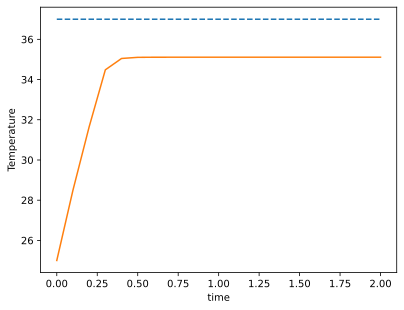

In [6]:
p_controller = PController(Kp=0.2, set_point=T_desired)
simulate_temp(p_controller)

Zoals je kunt zien, gaat de temperatuur van de melk omhoog, maar niet helemaal tot de waarde die we wilden. Er is nog steeds een verschil tussen de werkelijke temperatuur en de gewenste temperatuur. Dit staat bekend als stationaire fout en is een typisch probleem bij een `PController`.

In een echt systeem kan het moeilijk zijn te begrijpen waarom er een stationaire fout is, omdat we misschien niet eens een model van het systeem hebben. Voor ons gesimuleerde melksysteem kunnen we het echter begrijpen: Stel dat de werkelijke temperatuur gelijk is aan de gewenste temperatuur. Dan is de fout `T_desired-T` nul en dus is `u=K_d * (T_desired-T)` ook nul. Dit betekent dat er geen warmte wordt toegevoegd en de melk afkoelt tot beneden `T==T_desired`. Een stationaire toestand wordt bereikt wanneer de warmte die door de fout wordt gegenereerd gelijk is aan de warmte die aan de kamer wordt verloren.

Nu zouden we het `set_point` kunnen verhogen naar "gewenste temperatuur plus een beetje extra". Dit zou de stationaire temperatuur verhogen en deze dichter bij onze gewenste temperatuur brengen. Maar er bestaat een veel betere oplossing! De proportionele-integrale of PI-regelaar!

## PI Regelaar
De formule voor de PI-regelaar is

$$u(t) = K_p e(t) + K_I \int_0^t e(t) dt$$

De besturingsvariabele is nu afhankelijk van het tijdsintegraal van de fout. Stel je de situatie van eerder voor: We hebben een P-regelaar, die dicht bij de gewenste temperatuur komt, maar er is nog steeds een verschil. Als we nu overschakelen naar een PI-regelaar, groeit de integraalterm $K_I \int_0^t e(t) dt$ na verloop van tijd en deze zal het verschil dichten. De integraalterm kijkt naar het verleden en zegt: "Hé, we zijn al een tijdje onder het `set_point` geweest! We zouden de warmte moeten verhogen!". Laten we de PI-regelaar implementeren en kijken hoe deze het probleem van de stationaire fout oplost:

In [7]:
class PIController:
    def __init__(self, Kp, Ki, set_point):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = set_point
        self.int_term = 0
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        self.int_term += error*self.Ki*dt
        return self.Kp * error + self.int_term

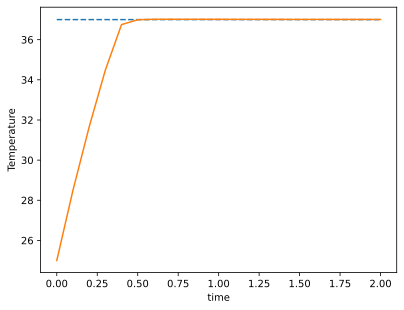

In [8]:
pi_controller = PIController(Kp=0.2, Ki = 0.15, set_point=T_desired)
simulate_temp(pi_controller)

We zijn nu best tevreden met onze melk. Voor dit probleem is de PI-regelaar een mooie oplossing. Er zijn echter andere problemen waarbij het misschien niet voldoende is om met de integraalterm naar het verleden te kijken. We moeten ook naar de toekomst kijken. Dit is wat de differentieelterm in de PID-regelaar doet.

## PID Regelaar
De formule van de PID-regelaar is

$$u(t) = K_p e(t) + K_I \int_0^t e(t) dt + K_d \frac{de}{dt}$$

en de implementatie ziet er als volgt uit:

In [9]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, set_point):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.set_point = set_point
        self.int_term = 0
        self.derivative_term = 0
        self.last_error = None
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        self.int_term += error*self.Ki*dt
        if self.last_error is not None:
            self.derivative_term = (error-self.last_error)/dt*self.Kd
        self.last_error = error
        return self.Kp * error + self.int_term + self.derivative_term

Voor ons melkprobleem behalen we niet veel voordeel met de PID-regelaar. Hieronder vind je een interactieve simulatie van het melksysteem, waar je met de parameters $K_p, K_i, K_d$ kunt spelen met behulp van schuifbalken. Je zou moeten opmerken dat de differentieelterm hier eigenlijk niet veel helpt.

In [10]:
# Import JavaScript simulation from another github repo
# JavaScript code was manually generated based on the python code from this chapter
from IPython.display import IFrame
IFrame('https://thomasfermi.github.io/PID-Playground-Temperature/', width=700, height=600)

In [11]:
# create sliders for interactive simulation via python
# Does not work inside Jupyter Book; only in notebook environment
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
def run_pid_temp(Kp,Ki,Kd):
    pid_controller = PIDController(Kp, Ki, Kd, set_point=T_desired)
    simulate_temp(pid_controller)

Kp_slider = FloatSlider(min=0.0, max=0.8, step=0.05, readout_format='.4f')
Ki_slider = FloatSlider(min=0.0, max=0.2, step=0.01, readout_format='.4f')
Kd_slider = FloatSlider(min=-3e-3, max=3e-3, step=2e-4, readout_format='.4f')
interact(run_pid_temp, Kp=Kp_slider, Ki=Ki_slider, Kd=Kd_slider);

interactive(children=(FloatSlider(value=0.0, description='Kp', max=0.8, readout_format='.4f', step=0.05), Floa…

Er zijn echter problemen waarbij de differentieelterm van de PID-regelaar zeer belangrijk is. Stel je een drone voor die op een hoogte $p$ boven de grond vliegt. We willen dat deze op een gewenste hoogte van $p=p_d=50$ meter blijft. We kunnen de opwaartse versnelling $a$ van de drone regelen (dus $u=a$) en moeten er rekening mee houden dat er een constante neerwaartse versnelling $g$ is vanwege de zwaartekracht.
Laten we kijken naar een simulatie van de drone. De toestand van de simulatie bestaat uit de positie en snelheid van de drone. De regelaar meet alleen de positie en geeft een versnellingscommando. Merk op dat je de details van de simulatiecode niet hoeft te begrijpen.

In [12]:
g = -9.81
p_desired = 50

# system update
def next_state(a, state, dt):
    aeff = a + g
    position, velocity = state 
    # integration by velocity verlet algorithm
    position += velocity*dt + 0.5*aeff*dt**2
    velocity += aeff*dt
    return (position,velocity)

def simulate_drone(controller, num_steps = 1000):
    dt = 0.02
    state = (0,0)
    state_list=[state]
    for i in range(num_steps):
        a = controller.get_control(state[0], dt)
        # upwards acceleration is positive (>0)
        # and limited by power supply (<100)
        a = np.clip(a, 0, 100)
        state = next_state(a, state, dt)
        state_list.append(state)
    s = np.array(state_list)
    time = dt*np.arange(num_steps+1)
    plt.plot(time, [p_desired]*(num_steps+1), ls="--")
    plt.plot(time, s[:,0])
    plt.gca().set_ylim(-100,100)
    plt.xlabel("time"); plt.ylabel("drone height");

Met behulp van de interactieve simulatie hieronder, probeer waarden van $K_p, K_i, K_d$ te vinden waarmee de drone op 50 meter hoogte blijft zweven. Je zult hier alle drie de termen van de PID-regelaar moeten gebruiken.

In [13]:
# Import JavaScript simulation from another github repo
# JavaScript code was manually generated based on the python code from this chapter
from IPython.display import IFrame
IFrame('https://thomasfermi.github.io/PID-Playground-Drone/', width=700, height=600)

In [14]:
# create sliders for interactive simulation via python
# Does not work inside Jupyter Book; only in notebook environment
def run_pid_drone(Kp,Ki,Kd):
    pid_controller = PIDController(Kp, Ki, Kd, set_point=p_desired)
    simulate_drone(pid_controller)

Kp_slider = FloatSlider(min=0, max=10, step=0.1, readout_format='.4f')
Ki_slider = FloatSlider(min=0.0, max=0.5, step=0.05, readout_format='.4f')
Kd_slider = FloatSlider(min=-3, max=3, step=0.1, readout_format='.4f')
interact(run_pid_drone, Kp=Kp_slider, Ki=Ki_slider, Kd=Kd_slider);

interactive(children=(FloatSlider(value=0.0, description='Kp', max=10.0, readout_format='.4f'), FloatSlider(va…

Je zou parameters moeten vinden waarbij de besturing soepel werkt. Wanneer je de differentiële term niet gebruikt, zul je merken dat de drone rond de doelpositie oscilleert. Maar waarom? Als de drone te laag is, zal de regelaar ervoor zorgen dat deze zijn opwaartse positie verhoogt, zodat hij de doelpositie kan bereiken. Maar eenmaal op die positie heeft hij nog steeds wat opwaartse beweging en zal dus blijven stijgen. Deze overshoot door traagheid kan worden aangepakt door de differentiële term, welke is

$$u(t) = K_d \frac{de}{dt} = K_d \frac{d}{dt}\bigg(p_d-p(t)\bigg) = K_d \left(0-\frac{dp}{dt}\right) = -K_d \frac{dp}{dt}$$

Er van uitgaande dat $K_d>0$ toont de formule hierboven aan: Als de snelheid $dp/dt$ positief is (opwaarts), dan zal de besturing $u$, wat de versnelling $a$ is, negatief zijn (neerwaarts). Daarom werkt de differentiële term tegen het probleem van overshoot en oscillatie.

In dit gedeelte hebben we de PID-parameters $K_p, K_i, K_d$ altijd handmatig afgesteld. Voor deze toepassing is dit voldoende. Maar als je meer wilt leren over meer methodische en zelfs automatische afstelmethoden, bekijk dan het Wikipedia Artikel over PID.

Voordat we onze introductie tot PID afronden, noemen we kort de beperkingen ervan. Een van de voordelen is tegelijkertijd een nadeel: de onafhankelijkheid van een systeemmodel. PID reageert uitsluitend op de fout. Als je geen model hebt, is dit geweldig, want je kunt misschien iets besturen dat je niet in detail begrijpt. Echter, als je wel een model hebt, zal het de capaciteit van je PID-regelaar niet verbeteren. Als je niet tevreden bent met de prestaties van de PID-regelaar, kan een modelgebaseerde regelaar in dit geval een betere keuze zijn.
Er is ook een probleem met PID genaamd integral windup. Als het ingestelde punt ver van de huidige waarde ligt, kan de integraalterm zich ophopen en erg groot worden terwijl het systeem naar het ingestelde punt beweegt. Dit zal leiden tot een overshoot. Gelukkig kan dit probleem worden opgelost door de implementatie van de `PIDController` licht aan te passen. Bijvoorbeeld, je kunt de integraalterm knippen, wat betekent dat je het niet toestaat om te groeien voorbij een door de gebruiker gespecificeerde drempel.

```{tip}
Voor meer details, zie [Wikipedia Article](https://en.wikipedia.org/wiki/PID_controller) of dit [youtube playlist by Brian Douglas](https://www.youtube.com/playlist?list=PLn8PRpmsu08pQBgjxYFXSsODEF3Jqmm-y). 
```